# Manual Backprogation

In [2]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('/kaggle/input/nn-zere-hero/names.txt', 'r').read().splitlines()
len(words)
max(len(w) for w in words)
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s : i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {s : i for i, s in stoi.items()}
print(itos)
vocab_size = len(itos)
print('vocabulary_size: ', vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocabulary_size:  27


In [5]:
block_size = 3 # context length

def build_dataset(words):
    X = []
    Y = []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr , Ytr = build_dataset(words[:n1]) # training set 80%
Xval,  Yval = build_dataset(words[n1:n2]) # validation set # 10%
Xte, Yte = build_dataset(words[n2:])  # test set # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# utility function for comparing manual gradients to pytorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [30]:
# MLP 
n_embd = 10 # the dimentionality of character embedding vectors
n_hidden =  64 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647) # for reproducibily
C = torch.randn((vocab_size, n_embd),    generator = g)

# layer1 
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size) **0.5) # kiminig initialization
b1 = torch.randn(n_hidden,       generator = g) * 0.1 # using b1 anyway, it's useless becuase of batch normalization

# layer2
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.1
b2 = torch.randn(vocab_size ,     generator = g)

# BatchNorm parameter
bngain = torch.randn((1,n_hidden)) *0.1 + 1.0
bnbias = torch.randn((1,n_hidden)) * 0.1


# note: Initializing many of these parameters in non-standard ways
# because sometimes initializing with e.g all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [31]:
batch_size = 32
n = batch_size # a shorter variable just for convinece
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
Xb , Yb = Xtr[ix], Ytr[ix] # batch X, Y


In [32]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
#Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim = True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1 / (n-1)* (bndiff2).sum(0, keepdim = True) # note: Bessel's correction (diving by n-1, not n)
bnvar_inv = (bnvar + 1e-5) **-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# hidden layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim = True).values
norm_logits = logits - logit_maxes # subtract max for numerical statbility
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim = True)
counts_sum_inv = counts_sum**-1 # if I use(1.0 /counts_sum) instead then I can't get backprop to bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Pytorch backward pass
for p in parameters:
    p.grad = None
    
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, #africk there is no cleaner war
         norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss




tensor(3.8419, grad_fn=<NegBackward0>)

In [10]:
emb.shape, C.shape, Xb.shape
Xb[:5]

tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])

In [11]:
hprebn.shape, embcat.shape, W1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [12]:
dembcat = dhprebn @ W1.T
dw1 = embcat.T @ dhprebn
b1 = dhpredn.sum(0)

NameError: name 'dhprebn' is not defined

In [ ]:
dbnvar_inv = (bndiff * dbnrawa).sum(0, keepdim = True)
dbndiff = bnvar * dbnraw

In [ ]:
dbngain = (bnraw * hpreact).sum(0, keepdim = True)
dbnraw = bngain * hpreact
dbnbias = dhpreact.sum(0, keepdim = True)

In [33]:
## Exercise 1: backprop through the whole thing manually
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above,one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0/ probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim = True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-(counts_sum**-2) * dcounts_sum_inv)
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim = True)
dlogits += F.one_hot(logits.max(1).indices, num_classes = logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j] 

cmp('dlogprobs', dlogprobs, logprobs)
cmp('dprobs', dprobs, probs)
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp("dcounts_sum", dcounts_sum, counts_sum)
cmp('dcounts', dcounts, counts)
cmp('dnorm_logits',dnorm_logits,norm_logits)
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)
cmp('dlogits',dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

dlogprobs       | exact: True  | approximate: True  | maxdiff: 0.0
dprobs          | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0
dcounts         | exact: True  | approximate: True  | maxdiff: 0.0
dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0
dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
dlogits         | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw   

In [34]:
# Exercise2 : backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simply the expression, and just write it out


# forward pass

# before
# logit_maxes = logits.max(1, keepdim = True).values
# norm_logits = logits - logit_maxes # subtract max for numerical statbility
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdim = True)
# counts_sum_inv = counts_sum**-1 # if I use(1.0 /counts_sum) instead then I can't get backprop to bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff: ', (loss_fast - loss).item())

3.8418736457824707 diff:  0.0


In [35]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('dlogits', dlogits, logits)

dlogits         | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


In [36]:
F.softmax(logits, 1)[0]

tensor([0.0865, 0.0193, 0.0128, 0.0181, 0.0061, 0.1944, 0.0696, 0.0672, 0.0147,
        0.0088, 0.0165, 0.0064, 0.0598, 0.0120, 0.0059, 0.0118, 0.0042, 0.0043,
        0.0067, 0.1342, 0.0528, 0.0038, 0.0260, 0.0344, 0.1101, 0.0102, 0.0034],
       grad_fn=<SelectBackward0>)

In [37]:
dlogits[0] * n

tensor([ 0.0865,  0.0193,  0.0128,  0.0181,  0.0061,  0.1944,  0.0696,  0.0672,
        -0.9853,  0.0088,  0.0165,  0.0064,  0.0598,  0.0120,  0.0059,  0.0118,
         0.0042,  0.0043,  0.0067,  0.1342,  0.0528,  0.0038,  0.0260,  0.0344,
         0.1101,  0.0102,  0.0034], grad_fn=<MulBackward0>)

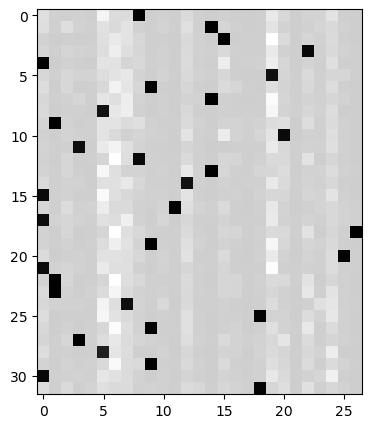

In [38]:
plt.figure(figsize =(5,5))
plt.imshow(dlogits.detach(), cmap = 'gray')

In [39]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [40]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------

dhprebn = bngain * bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact * bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [46]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

    # kick off optimization
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        #loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop! #swole_doge_meme
        # -----------------
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        dhpreact = (1.0 - h**2) * dh
        dhprebn = bngain * bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact * bnraw).sum(0))
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix] += demb[k,j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        # -----------------

        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

    #     if i >= 10000: # TODO: delete early breaking when you're ready to train the full net
    #         break

12297
      0/ 200000: 3.7961
  10000/ 200000: 2.1493
  20000/ 200000: 2.4002
  30000/ 200000: 2.4349
  40000/ 200000: 1.9819
  50000/ 200000: 2.3766
  60000/ 200000: 2.4128
  70000/ 200000: 2.0216
  80000/ 200000: 2.3025
  90000/ 200000: 2.1236
 100000/ 200000: 1.9366
 110000/ 200000: 2.3024
 120000/ 200000: 1.9163
 130000/ 200000: 2.4490
 140000/ 200000: 2.3989
 150000/ 200000: 2.1295
 160000/ 200000: 1.9918
 170000/ 200000: 1.8317
 180000/ 200000: 2.0077
 190000/ 200000: 1.9071


In [42]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#       cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 1.210719347000122e-08
(200,)          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [47]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [48]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.071704387664795
val 2.1113476753234863


In [51]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 +10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmahzamille.
khy.
mrix.
taty.
sacassie.
mahnen.
delynn.
jareei.
nellara.
chaiivon.
leigh.
ham.
jocn.
quinn.
shon.
marianni.
wavero.
dearyxi.
jace.
pirra.
